# Is It Real, or Just Luck?

One of the main problems of making inferences from data is that our brains are wired to see what we want to see. We can't help it! We're human. Our beliefs have a tendency to cloud our judgement. It's an understatment to say that a lot of work has been done attempting to systematize the process of evaluating data to determine if an effect is real or just a "statistical fluctuation". One of the main approaches, which I'm sure you'll encounter at some point, is the idea of [Null Hypothesis Testing](https://imsmwu.github.io/MRDA2017/_book/hypothesis-testing.html). This is the idea that you first propose a question which is actually the *opposite* of what you really *hope* you'll measure, and then you go about proving that the answer to this "null-hypothesis" question, what you hope is *not* correct, is actually *not* correct. This gets to be pretty complicated an confusing very quickly, so much so, that there are now armies of statistical experts who's entire job is to explain this idea to the rest of us so we can move on with our lives. These experts also provide tools (usually in the form of complex computer programs) and rules like these (from Mcelreath, Statistical Rethinking):

![Flow Chart for Statistical Tests for Hypothesis Testing](https://imsmwu.github.io/MRDA2017/_book/_main_files/figure-html/unnamed-chunk-101-1.png)

Unless you are one of these statistical experts, you are doomed to using a chart like this to choose among a litany of statistical tests that are specifically designed for somewhat specialized situations, that may be (almost certinaly are) subtly different from your *actual* situation, but maybe close enough, (but maybe not!). So you try to find a statistical test, according to some recipe, like that above, that comes *close* to what you're facing and the you go about trying to prove that the answer to the question you don't care about (the null hypothesis) is "no" which means that (maybe) the answer to the question you actually *do* care about is "yes". Bleah. It's a mess.

# The Bayesian Approach

If you look in this repository you'll find two [previous](OLD%20Hypothesis%20Testing%20(No%20Longer%20Used).ipynb) [notebooks](REALLY_OLD_HypothesisTesting_NOTEBOOK_Ignore.ipynb) from prior years where I attempted to teach the traditional null hypothesis testing business. It's hard. Folks were confused! This year, I'm trying something completely different. We're going 100% [Bayesian](https://en.wikipedia.org/wiki/Bayesian_statistics). This means we don't need to worry about "what's a null hypothesis", or "what's a p-value". Yeah! I feel better already. However we do need to learn some tools to make Bayesian inference easier. In fact the concept of "is it real or just a statistical fluctuation" is much more straightforward. Now were simply asking "how big is the effect?". That's actually the question we wanted in the first place. Yeah!

If you're interested in some more background for this approach, here a nice video from Mcelreath himself.

[Bayesian Inference is Just Counting](https://youtu.be/_NEMHM1wDfI)

Of course, it's not required, just fun.


## Previous Problems

You've already used Bayesian inference in some examples (remember the socks in the drawers? or the four-sided, six-sided, and eight-sided dice?). You've also seen some generative models (e.g., the diode model, and the transistor model). Our basic plan with statistical analysis for most of the rest of this semester will be to apply Bayesian analysis to glean meaning from the data we collect. Here's the setup:

1. We have a generative model with unknown parameters (our hypotheses) that, potentially, explain the data we measure. This model has to make *sense* (i.e., has some logical structure in which the parameters have meaning).
2. We collect data from the real world that could be produced by the generative model.
3. We use Bayesian update to determine the posterior probability distribution of the parameters in the model
4. We sample from the posterior distribution to make inferences from the data.

In order to make this as *easy* as possible, I'm introducing three new python modules. I know, that might sound intimidating, but we'll only be using a few functions from each module.

* [Arviz](https://github.com/arviz-devs/arviz) Visualization library for Bayesian Inference results.
* [Seaborn](https://seaborn.pydata.org) General Purpose statistical visualization library
* [PyMC3](https://docs.pymc.io) Bayesian Inference through Markov Chain Monte Carlo library.


Before you need to analyze your own data, let's work through some examples with these modules to see how they can work together to help you perform Bayesian inference.

## Example



In [1]:
import pymc as pm
import arviz as az
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import empiricaldist as emp
import pandas as pd

print(f"Running PyMC v{pm.__version__}")
print(f"Running ArviZ v{az.__version__}")
print(f"Running Seaborn v{sns.__version__}")
print(f"Running numpy v{np.__version__}")
print(f"Running matplotlib v{matplotlib.__version__}")


Running PyMC3 v5.0.2
Running ArviZ v0.14.0
Running Seaborn v0.12.2
Running numpy v1.24.2
Running matplotlib v3.7.0


Let's go back to one of our first statistical problems relating to a collection of normally distributed data. Do you recall this exercise?

Exercise 1 (DALO-3): Create a distribution of 10,000 random numbers drawn from a normal distribution with a mean of $\mu=25$ and a standard deviation of $\sigma=6$. 

Suppose we have some data we collected from a process that we believe should result in a single number (e.g., the light level in a room over a short period of time). This normal distribution might be reasonable if the light level is low, and the sensor is a bit "noisy".

Let's generate such a collection, and use seaborn to visualize the distribution:

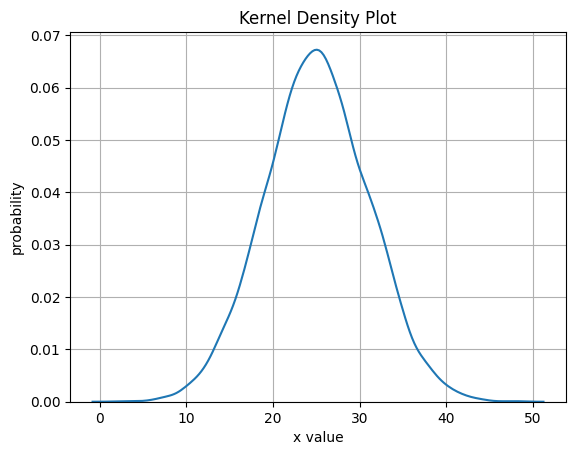

In [2]:
N = 10000
x = np.random.normal(size=N)*6 + 25
sns.kdeplot(x)
plt.xlabel('x value')
plt.ylabel('probability')
plt.title('Kernel Density Plot')
plt.grid()

## Just a simple "manual" example.

We're going to work this *two* ways. First, we'll use the empiricaldist `Pmf` object, just like the socks and the dice to compute the liklihood of each data point given each of the hypothetical parameters. Then we'll use the same Bayesian update strategy to compute the probability of the parameters given the data. Let's work out the priors first. Suppose we *know* that x is between 10 and 50, and we're pretty sure the standard deviation is less than 20. We can start with prior distributions for $\mu$ and $\sigma$ that are pretty broad, but reasonable. The simplest (though not necessarily the best) is probably a Uniform prior. 

**NOTE**: This is just an example to explain what's going on. You're not going to have to do this part yourself, just pay attention, think about this conceptually. Suppose we're thinking that all these sigmas and mus are equally probable. We could think of them as a set of hypotheses:

In [3]:
sigs = np.linspace(0,20,41)
mus = np.linspace(10,50,41)
sigs, mus

(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
        23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
        36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
        49., 50.]))

To do Bayesian update we'll create a PFM of these hyptheses that consist of every possible combination of mu and sigma from our prior distributions:

In [4]:
sigmu = []
[[sigmu.append((sig,mu)) for sig in sigs] for mu in mus]
print(sigmu[:10],"...")

[(0.0, 10.0), (0.5, 10.0), (1.0, 10.0), (1.5, 10.0), (2.0, 10.0), (2.5, 10.0), (3.0, 10.0), (3.5, 10.0), (4.0, 10.0), (4.5, 10.0)] ...


In [5]:
hypos = emp.Pmf(1,sigmu)
hypos.normalize()
hypos.head()

,probs
"(0.0, 10.0)",0.000595
"(0.5, 10.0)",0.000595
"(1.0, 10.0)",0.000595


Remember the normal distribution?

$$ P(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

We can use this to evaluate the relative liklihood for each value of the parameters:

In [6]:
def liklihoodForData(data, sigma, mu):
    """
    Return the relative liklihood that data came from a normal distribution with a 
    mean of mu and a standard deviation of sigma.
    """
    if sigma == 0:
        return 0 # cannot have a sigma of zero!
    
    return np.exp(-(data-mu)**2/(2*sigma**2))/sigma

def getLiklihoodsForHypos(data, hypos):
    """
    For each hypothesis, compute the likihood of seeing this data
    """
    liklihoods = []
    for (sig, mu) in hypos.index:
        liklihoods.append(liklihoodForData(data, sig, mu))
    return liklihoods

def updateHypos(dataList, hypos):
    """
    For every data point, go through all the hypotheses and update the probability of each
    according to the liklihood of that data coming from each hypothesis.
    """
    
    for data in dataList:
        hypos = hypos*getLiklihoodsForHypos(data, hypos)

    hypos.normalize()
    return hypos

In [7]:
#
# Let's create a set of hypothesis, and send in 100 data points to manually update the posterior
#

hypos = emp.Pmf(1,sigmu)                     # all sigmas and mus are equally likely to begin
hypos = updateHypos(x[:100], hypos)          # update probabilities with 100 data points only.
print("max prob:", max(hypos))               # what is the maximum probability of any hypothesis?
print("at index:", np.argmax(hypos.values))  # what is the index in the list of hypotheses?
print("sig,mu=", hypos.index.values[np.argmax(hypos.values)]) # what are the values of sigma and mu?

max prob: 0.23642289867880728
at index: 668
sig,mu= (6.0, 26.0)


Text(0.5, 1.0, 'posterior distribution after considering 100 data points')

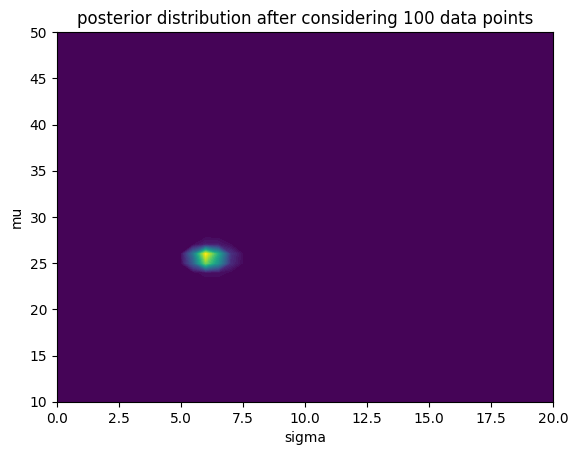

In [8]:
SIG, MU = np.meshgrid(sigs, mus)
POST = np.zeros(shape=SIG.shape)
for i in range(len(mus)):
    for j in range(len(sigs)):
        POST[i,j] = hypos.values[i*len(sigs)+j]

plt.contourf(SIG,MU,POST,levels=50)
plt.xlabel('sigma')
plt.ylabel('mu')
plt.title("posterior distribution after considering 100 data points")

Note that from the originally uniform prior we have narrowed it down to a pretty tiny region of the "parameter space" 

Let's put all this code in a general function that does all the work!

In [9]:
def BruteForceGrid(minSig, maxSig, Nsig, minMu, maxMu, Nmu, x):
    sigs = np.linspace(minSig,maxSig,Nsig)
    mus = np.linspace(minMu,maxMu,Nmu)
    sigmu = []
    [[sigmu.append((sig,mu)) for sig in sigs] for mu in mus]
    hypos = emp.Pmf(1,sigmu)
    hypos = updateHypos(x, hypos)
    print("max prob:", max(hypos)) # what is the maximum probability?
    print("at index:", np.argmax(hypos.values))
    print("sig,mu=", hypos.index.values[np.argmax(hypos.values)])
    SIG, MU = np.meshgrid(sigs, mus)
    POST = np.zeros(shape=SIG.shape)
    for i in range(len(mus)):
        for j in range(len(sigs)):
            POST[i,j] = hypos.values[i*len(sigs)+j]

    plt.contourf(SIG,MU,POST,levels=50)
    plt.xlabel('sigma')
    plt.ylabel('mu')
    plt.title("posterior distribution after considering %d data points" % len(x))
    

Now let's validate that the function produces the same result as our original analysis for the same settings:

max prob: 0.23642289867880728
at index: 668
sig,mu= (6.0, 26.0)


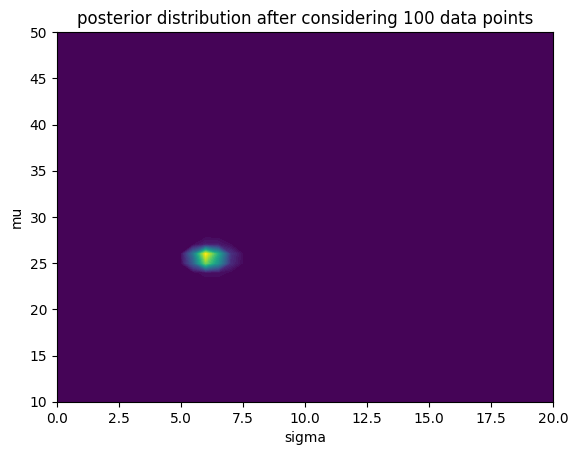

In [10]:
BruteForceGrid(0, 20, 41, 10, 50, 41, x[:100])

Good! Now we can re-do the calculation but focus on the part that's most likely. Let's focus the grid over the region of the parameter space where the coarse grid shows the most liklihood.

max prob: 0.0006497018600339971
at index: 6485
sig,mu= (6.025, 25.56)


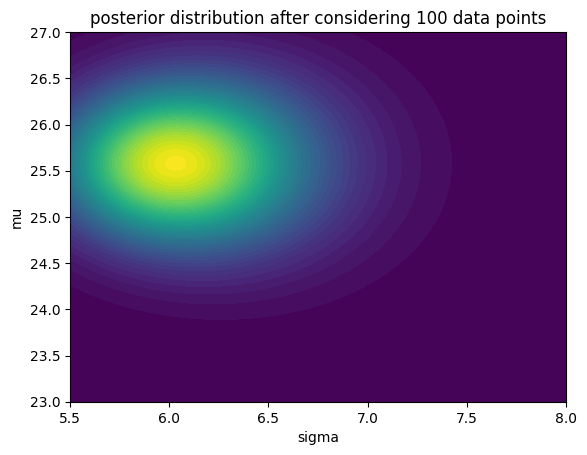

In [11]:
BruteForceGrid(5.5, 8, 101, 23, 27, 101, x[:100])

So you can see we increased the number of samples which improves the "resolution" of the calculation, but it also takes a lot longer to compute! Also, note we're only using 100 data points out of 10,000! Let's increase the number of data points and see what happpens:

max prob: 0.0013752098666866192
at index: 4863
sig,mu= (5.875, 24.92)


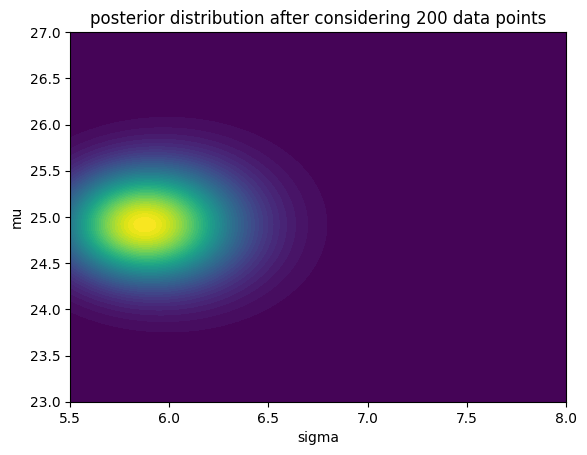

In [12]:
BruteForceGrid(5.5, 8, 101, 23, 27, 101, x[:200])

Notice that as we add more data, the posterior distribution becomes more narrow. It's just like the fruit basket and the dice. As we collect more data, the "credible interval" narrows and more of posterior is focused on a smaler and smaller region.

## Manual is hard

This is all well and good, but it's a lot of work, and it's not very fast. As our data sets grow, it's not going to be practical to use this "brute force" approach. The good news is folks have been working hard to provide alternatives. Conceptually, they are doing the same basic thing, but the machinery is just more more efficient and advanced. You'll note that our brute force method spent exactly as much time calculating probabilities in regions where the final probablility was super low. What a waste! These new methods are very clever about exploring the parameter space in a way the spends most of the time in regions where the final posterior probability is likely to be large, and very little time in regions where the postierior looks to be small. This method is called "[Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)". This is the method we'll be using for the rest of the semester, and we'll "redo" this example using these libraries.

First let's use the same uniform prior for mu and sigma:

In [13]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=10, upper=50) # somewhere between 10 and 50
    sigma = pm.Uniform("sigma", lower=0, upper=20) # Must be positive. Less than 20
    x_obs = pm.Normal("x_obs", mu=mu, sigma=sigma, observed=x[:100])

Note the `with` syntax is very important. We're creating a model, giving it a name and defining parameters in that context. The variables `mu` and `sigma` are parameters, and `x_obs` is the observed data.

In [14]:
model

   mu ~ U(10, 50)
sigma ~ U(0, 20)
x_obs ~ N(mu, sigma)

This next function `sample` finds the posterior distribution after the observations and samples the parameters from that distribution.

In [15]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


The `az.summary` function prints summary statistcs from the posterior.

In [16]:
az.summary(trace,kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,25.579,0.621,24.425,26.766
sigma,6.140,0.448,5.295,6.952


Note that we get the mean values of the parameters, the standard deviation, as well as the 3% and 97% bounds of the "Highest Density Interval" (so 94% of the probability lies bewteen these two points).

The `az.plot_trace` function plots the distributions themselves so we can *see* the distributions directly.

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

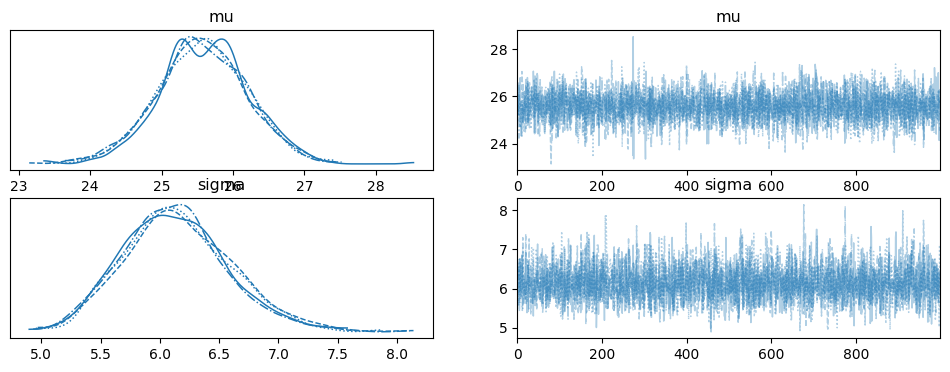

In [17]:
az.plot_trace(trace)

On my computer the Markov Chain Monte Carlo (MCMC) was run on four cores, you may have more or fewer cores on your computer so you have more or fewer chains. You can see the KDE plots from the four chains graphed for each parameter, along with "time-series" plots of the actual search through parameter space by the MCMC algorithm. These graphs have a "fuzzy caterpillar" look to them, which is good and expected, so we know that the search was relatively efficient. If you see the parameters getting "stuck" along the way, it means there's something broken in your model.

<Axes: xlabel='sigma', ylabel='mu'>

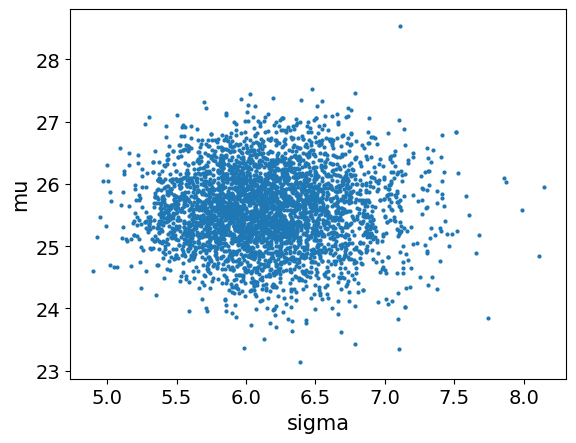

In [18]:
az.plot_pair(trace, var_names=['sigma','mu',])

Notice how similar it looks to the brute force calculation we did before! You can see samples of the parameters taken throughout the MCMC search process. Rather than the systematic "brute force" grid approach, MCMC, randomly samples its way through the parameter space. It's similar conceptually, but it's *much* faster to extend the amount of data. Let's go for 10,000 data points now, the whole lot:

In [19]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=10, upper=50) # somewhere between 10 and 50
    sigma = pm.Uniform("sigma", lower=0, upper=20) # Must be positive. Less than 20
    x_obs = pm.Normal("x_obs", mu=mu, sigma=sigma, observed=x) # all the data. Woohoo!
    trace = pm.sample(1000, return_inferencedata=True)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Wow! 10,000 data points, and it only took 15 seconds! (Actually, every time you run this notebook it could be a different time, but you get the idea!) Let's look at the parameters now:

,mean,sd,hdi_3%,hdi_97%
mu,25.056,0.059,24.946,25.167
sigma,5.990,0.042,5.912,6.068


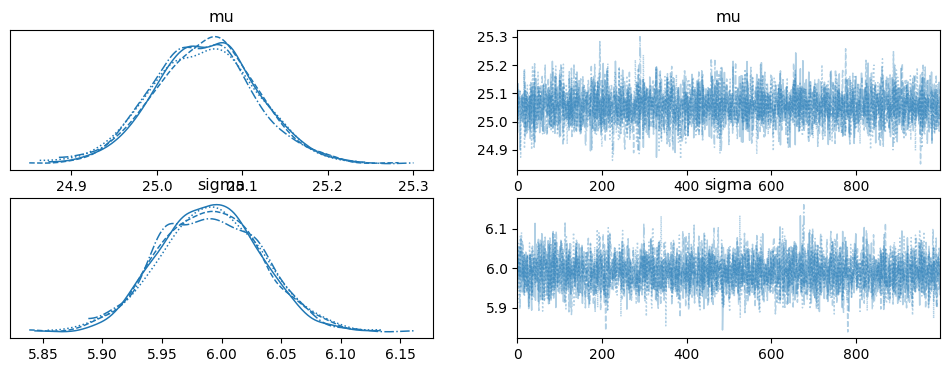

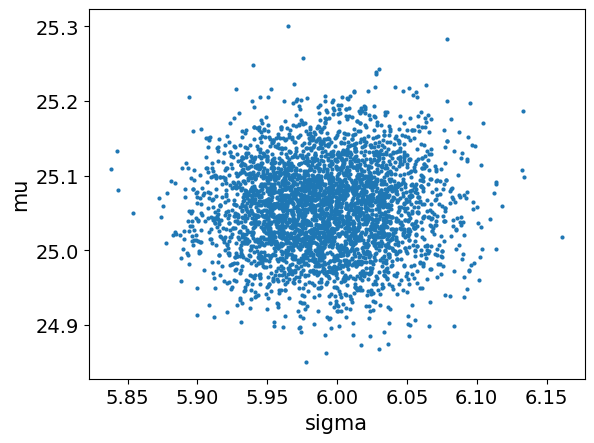

In [20]:
az.plot_trace(trace)
az.plot_pair(trace, var_names=['sigma','mu',])
az.summary(trace,kind="stats")

Note how much *narrower* the range of credible values is now. Using *all* the data we have a *much* clearer idea of what the parameters actually are. Note also that it only took 16 seconds!

Let's do one last example that will be similar to your project 4 analysis. You measure something before and after you make some change (e.g., a treatment, or a modification). You're interested to see if there is a real difference. Let's fabricate some data using a generative model. Let's create data for which we know there *is* a real difference, and let's see how much data we need to be able to demonstrate that difference.

In [21]:
N = 10   # let's create N points of data.
mu1_0 = 6.5  # mu 1 zero, the generative value, is a bit higher.
mu2_0 = 5.5  # mu 2 zero, the generative value is a bit lower.
sigma_0 = 1.4 # let's give the the same sigma zero.

x1 = np.random.normal(size=N)*sigma_0 + mu1_0 # data for x1
x2 = np.random.normal(size=N)*sigma_0 + mu2_0 # data for x2

with pm.Model() as two_element_model:
    mu1 = pm.Uniform("mu1", lower=2, upper=10) # prior somewhere between 2 and 10
    mu2 = pm.Uniform("mu2", lower=2, upper=10) # prior somewhere between 2 and 10
    sigma = pm.Uniform("sigma", lower=0, upper=5) # Must be positive. Less than 5
    x1_obs = pm.Normal("x1_obs", mu=mu1, sigma=sigma, observed=x1)
    x2_obs = pm.Normal("x2_obs", mu=mu2, sigma=sigma, observed=x2)
    delta_mu = pm.Deterministic("difference of means", mu1 - mu2)
    two_el_trace = pm.sample(1000, return_inferencedata=True)
    
    

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%
mu1,6.988,0.513,6.036,7.976
mu2,5.395,0.498,4.409,6.310
sigma,1.579,0.288,1.091,2.113
difference of means,1.593,0.721,0.208,2.917


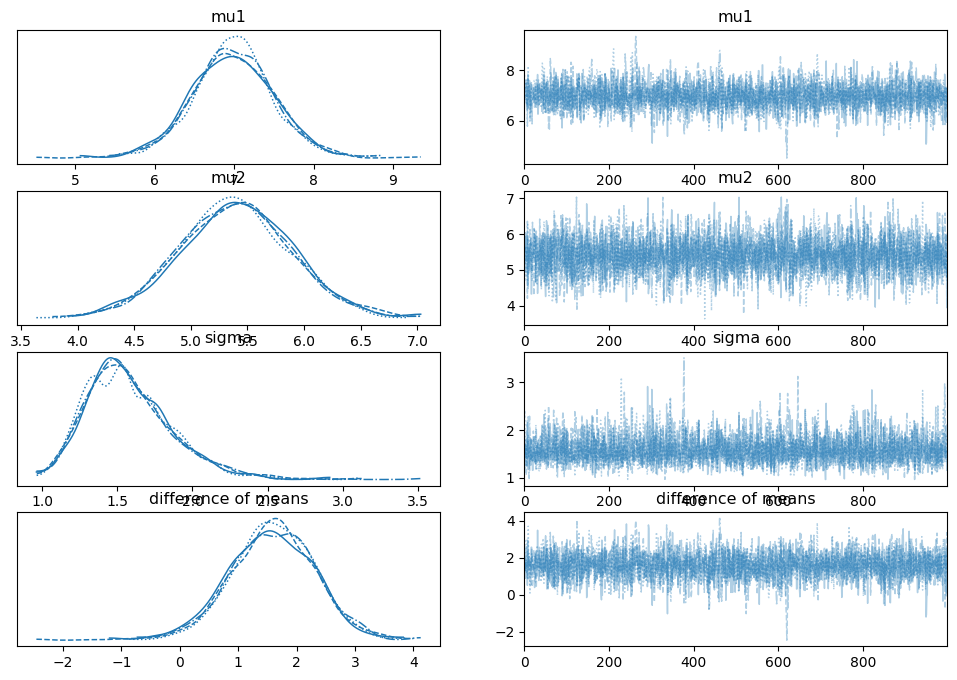

In [22]:
az.plot_trace(two_el_trace)
az.summary(two_el_trace, kind="stats")

With such little data, it's hard to say if the means are different or not. Certinaly zero difference is consistent with the data. You cannot reject that possibility. However, what happens if we add more data?

In [23]:
N = 100   # let's create N points of data.
mu1_0 = 6.5  # mu 1 zero, the generative value, is a bit higher.
mu2_0 = 5.5  # mu 2 zero, the generative value is a bit lower.
sigma_0 = 1.4 # let's give the the same sigma zero.

x1 = np.random.normal(size=N)*sigma_0 + mu1_0 # data for x1
x2 = np.random.normal(size=N)*sigma_0 + mu2_0 # data for x2

with pm.Model() as two_element_model:
    mu1 = pm.Uniform("mu1", lower=2, upper=10) # prior somewhere between 2 and 10
    mu2 = pm.Uniform("mu2", lower=2, upper=10) # prior somewhere between 2 and 10
    sigma = pm.Uniform("sigma", lower=0, upper=5) # Must be positive. Less than 5
    x1_obs = pm.Normal("x1_obs", mu=mu1, sigma=sigma, observed=x1)
    x2_obs = pm.Normal("x2_obs", mu=mu2, sigma=sigma, observed=x2)
    delta_mu = pm.Deterministic("difference of means", mu1 - mu2)
    two_el_trace = pm.sample(1000, return_inferencedata=True)
    

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%
mu1,6.377,0.128,6.138,6.630
mu2,5.606,0.133,5.353,5.857
sigma,1.329,0.067,1.197,1.445
difference of means,0.771,0.187,0.420,1.135


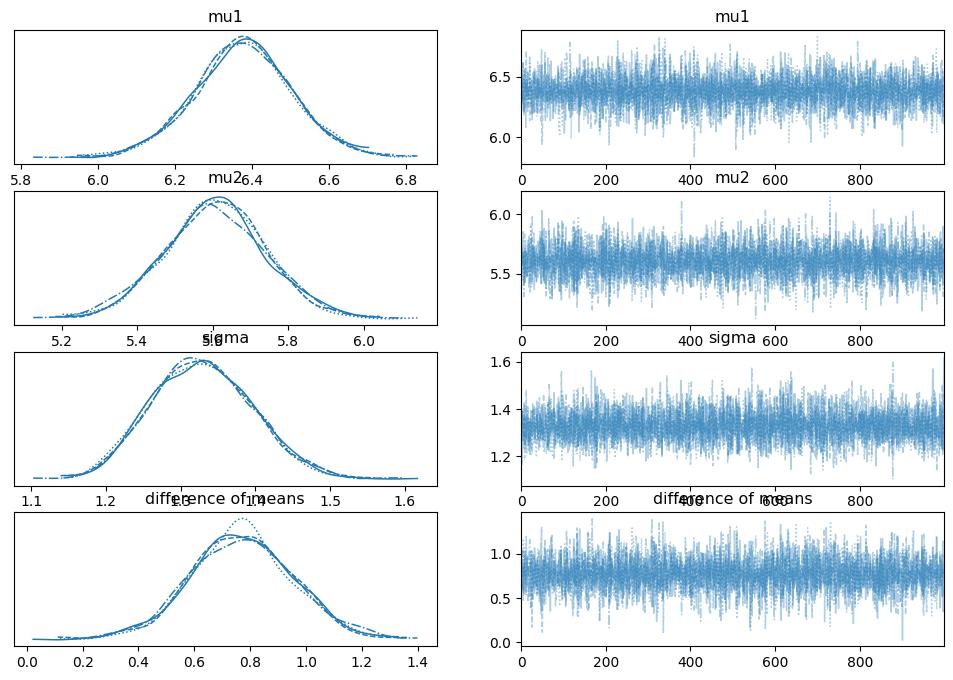

In [24]:
az.plot_trace(two_el_trace)
az.summary(two_el_trace, kind="stats")

Now we can see that with this much data, it's *very* unlikely that the means are different. This is so easy and clear, and so much more straighforward than null-hypothesis testing (NHT). Nice. Note that there are many tricks and subtleties to this business as well, and we're really just going to scratch the surface, but it's a much nicer foundation to build upon, so enjoy. ;-)

# Exercises

Exercise 1) You measure the following 10 data points:

In [25]:
df = pd.DataFrame(data = {'x':np.array([1.73463558, 1.66331533, 1.87292601, 1.1716075 , 0.75154392,
       1.56373077, 2.66792105, 2.99850011, 2.06616619, 2.35189101])})
df

,x
0,1.734636
1,1.663315
2,1.872926
3,1.171607
4,0.751544
5,1.563731
6,2.667921
7,2.998500
8,2.066166
9,2.351891


Use Markov Chain Monte Carlo (MCMC) to estimate the posterior distribution of the mean and standard deviation of this data set. What are the most likely values for mu and sigma? What are their intervals of credibility?

Exercise 2) From the data you collect from your [Project 4 experiment](Communication.ipynb), make the case that your sensor was functioning correctly. Come up with a *generative model* that produces data similar to the data you've collected. Explain how you use the output from MCMC to infer the parameters of the distribution(s) you selected for your generative model. Use the same process to analyze the actual data from your project and describe how the posterior distribution of the paramters of this model confirm that your measurement was working.